## Установка и импорты

In [ ]:
# Установка зависимостей
!pip install simpy matplotlib numpy --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

## Микросервис обработки изображений (ресурсы и процессы)
- Ресурс `workers`: GPU‑воркеры (s шт.) — основное обслуживание (инференс)
- Ресурс `preprocessors`: предобработка/валидация запроса (1–2 шт.) — быстрый шаг
- Процессы: предобработка → ожидание GPU‑воркера → инференс

In [26]:
class ImageService:
    def __init__(self, env, num_workers=4, num_preprocessors=1, mean_inference=1.5):
        self.env = env
        # GPU-воркеры (основной ресурс инференса)
        self.gpu_workers = simpy.Resource(env, capacity=num_workers)
        # Предобработка/валидация запроса (быстрый ресурс)
        self.preprocessors = simpy.Resource(env, capacity=num_preprocessors)
        self.mean_inference = mean_inference  # среднее время инференса (сек)

    def preprocess(self, request_id):
        # Быстрая предобработка/валидация запроса
        t = random.uniform(0.1, 0.2)
        yield self.env.timeout(t)

    def infer(self, request_id):
        # Инференс модели (экспоненциально распределенное время со средним mean_inference)
        t = random.expovariate(1.0 / self.mean_inference)
        yield self.env.timeout(t)
        return t

## Сбор метрик и процессы запросов

In [27]:
# Глобальные контейнеры метрик (обнуляются при каждом запуске симуляции)
waiting_times = []        # время ожидания у GPU-воркера
system_times = []         # полное время запроса в системе
service_times = []        # фактическое время инференса
in_system_time_series = []  # серия: число запросов в системе во времени
arrived = 0
served = 0

def request_process(env, rid, service: ImageService):
    global waiting_times, system_times, service_times, served
    arrival_time = env.now

    # 1) Предобработка/валидация запроса
    with service.preprocessors.request() as req_prep:
        yield req_prep
        yield env.process(service.preprocess(rid))

    # 2) Ожидание GPU-воркера и инференс
    wait_start = env.now
    with service.gpu_workers.request() as req_worker:
        yield req_worker
        wait = env.now - wait_start
        waiting_times.append(wait)
        svc = yield env.process(service.infer(rid))
        service_times.append(svc)

    # 3) Завершение обработки запроса
    total = env.now - arrival_time
    system_times.append(total)
    served += 1

def request_generator(env, service: ImageService, mean_interarrival=1.5):
    global arrived
    rid = 0
    while True:
        # Экспоненциальные интервалы между поступлениями запросов
        inter = random.expovariate(1.0 / mean_interarrival)
        yield env.timeout(inter)
        rid += 1
        arrived += 1
        env.process(request_process(env, rid, service))

def monitor_service(env, service: ImageService, dt=0.1):
    # Мониторинг числа запросов в системе (занятые GPU-воркеры + очередь)
    while True:
        num_in_system = service.gpu_workers.count + len(service.gpu_workers.queue)
        in_system_time_series.append(num_in_system)
        yield env.timeout(dt)

## Запуск симуляции и расчет метрик

In [28]:
def reset_metrics():
    global waiting_times, system_times, service_times, in_system_time_series, arrived, served
    waiting_times = []
    system_times = []
    service_times = []
    in_system_time_series = []
    arrived = 0
    served = 0

def run_simulation(num_workers=4, num_preprocessors=1, mean_inference=1.5, mean_interarrival=1.5, 
                   sim_time=2000, seed=42):
    """Запускает симуляцию микросервиса обработки изображений и возвращает метрики. Все времена — секунды."""
    reset_metrics()
    random.seed(seed)

    env = simpy.Environment()
    service = ImageService(env, num_workers=num_workers, num_preprocessors=num_preprocessors, mean_inference=mean_inference)
    env.process(request_generator(env, service, mean_interarrival=mean_interarrival))
    env.process(monitor_service(env, service, dt=0.1))
    env.run(until=sim_time)

    # Метрики
    avg_wait = mean(waiting_times) if waiting_times else 0.0
    avg_sys = mean(system_times) if system_times else 0.0
    avg_n = mean(in_system_time_series) if in_system_time_series else 0.0
    abs_thr = served / sim_time
    rel_thr = (served / arrived) if arrived > 0 else 0.0
    utilization = (sum(service_times) / (num_workers * sim_time)) if num_workers * sim_time > 0 else 0.0
    
    # Процентили времени ожидания
    p50_wait = np.percentile(waiting_times, 50) if waiting_times else 0.0
    p95_wait = np.percentile(waiting_times, 95) if waiting_times else 0.0
    p99_wait = np.percentile(waiting_times, 99) if waiting_times else 0.0

    return {
        'num_workers': num_workers,
        'num_preprocessors': num_preprocessors,
        'mean_inference': mean_inference,
        'mean_interarrival': mean_interarrival,
        'sim_time': sim_time,
        'arrived': arrived,
        'served': served,
        'avg_wait': avg_wait,
        'avg_system_time': avg_sys,
        'avg_in_system': avg_n,
        'throughput_abs': abs_thr,
        'throughput_rel': rel_thr,
        'utilization': utilization,
        'p50_wait': p50_wait,
        'p95_wait': p95_wait,
        'p99_wait': p99_wait,
        'waiting_times': waiting_times.copy(),
        'system_times': system_times.copy(),
        'service_times': service_times.copy(),
        'in_system_series': in_system_time_series.copy()
    }

def print_results(res):
    print('='*70)
    print('РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ (микросервис обработки изображений)')
    print('='*70)
    print(f"GPU-воркеров (s): {res['num_workers']}  | Предобработчиков: {res['num_preprocessors']}")
    print(f"Средн. межприход (μ_A): {res['mean_interarrival']} сек | Средн. инференс (μ_s): {res['mean_inference']} сек")
    print('-'*70)
    print(f"Поступило запросов: {res['arrived']} | Обработано: {res['served']}")
    print(f"Коэффициент использования (ρ): {res['utilization']:.4f} ({res['utilization']*100:.2f}%)")
    print(f"Среднее ожидание очереди: {res['avg_wait']:.4f} сек")
    print(f"  ├─ Медиана (P50): {res['p50_wait']:.4f} сек")
    print(f"  ├─ 95-й процентиль: {res['p95_wait']:.4f} сек")
    print(f"  └─ 99-й процентиль: {res['p99_wait']:.4f} сек")
    print(f"Среднее время в системе: {res['avg_system_time']:.4f} сек")
    print(f"Среднее число в системе: {res['avg_in_system']:.4f}")
    print(f"Абсолютная пропускная способность: {res['throughput_abs']:.4f} req/сек")
    print(f"Относительная пропускная способность: {res['throughput_rel']:.4f}")
    print('='*70)


## Базовый запуск (по варианту): s=4, μ_s=1.5 сек, μ_A=1.5 сек

In [29]:
base = run_simulation(num_workers=4, num_preprocessors=1, mean_inference=1.5, mean_interarrival=1.5, sim_time=2000, seed=42)
print_results(base)

РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ (микросервис обработки изображений)
GPU-воркеров (s): 4  | Предобработчиков: 1
Средн. межприход (μ_A): 1.5 сек | Средн. инференс (μ_s): 1.5 сек
----------------------------------------------------------------------
Поступило запросов: 1341 | Обработано: 1340
Коэффициент использования (ρ): 0.2648 (26.48%)
Среднее ожидание очереди: 0.0146 сек
  ├─ Медиана (P50): 0.0000 сек
  ├─ 95-й процентиль: 0.0000 сек
  └─ 99-й процентиль: 0.6326 сек
Среднее время в системе: 1.7538 сек
Среднее число в системе: 1.0687
Абсолютная пропускная способность: 0.6700 req/сек
Относительная пропускная способность: 0.9993


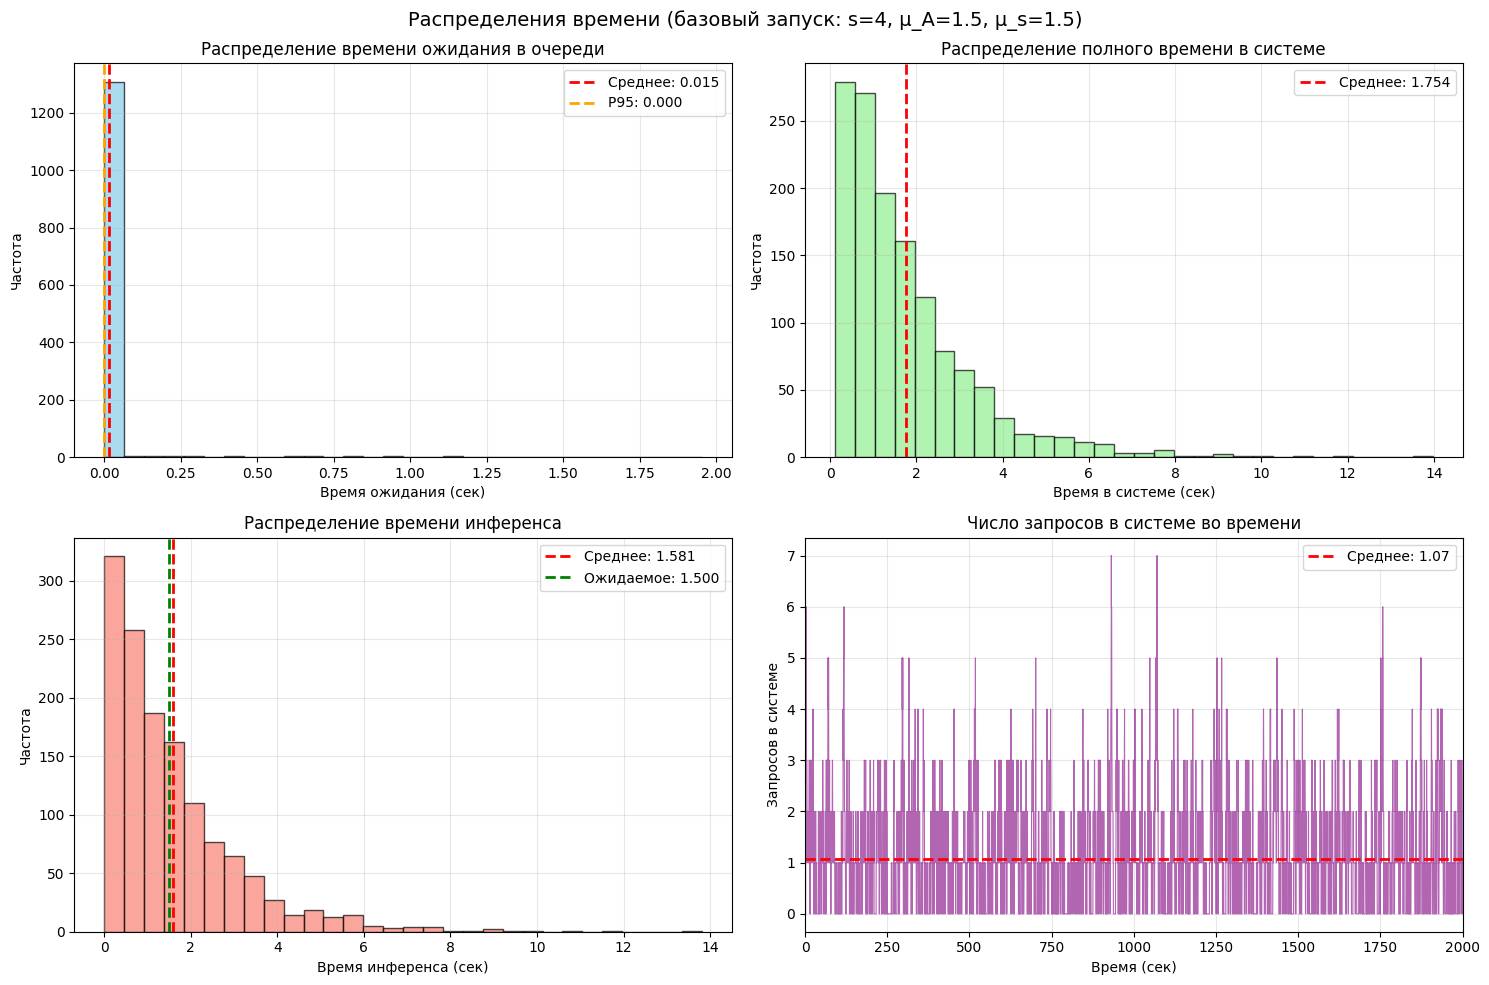

In [30]:
# Гистограммы распределений времени для базового запуска
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Распределения времени (базовый запуск: s=4, μ_A=1.5, μ_s=1.5)', fontsize=14)

# Гистограмма времени ожидания
axes[0,0].hist(base['waiting_times'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0,0].axvline(base['avg_wait'], color='red', linestyle='--', linewidth=2, label=f'Среднее: {base["avg_wait"]:.3f}')
axes[0,0].axvline(base['p95_wait'], color='orange', linestyle='--', linewidth=2, label=f'P95: {base["p95_wait"]:.3f}')
axes[0,0].set_title('Распределение времени ожидания в очереди')
axes[0,0].set_xlabel('Время ожидания (сек)')
axes[0,0].set_ylabel('Частота')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Гистограмма времени в системе
axes[0,1].hist(base['system_times'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0,1].axvline(base['avg_system_time'], color='red', linestyle='--', linewidth=2, label=f'Среднее: {base["avg_system_time"]:.3f}')
axes[0,1].set_title('Распределение полного времени в системе')
axes[0,1].set_xlabel('Время в системе (сек)')
axes[0,1].set_ylabel('Частота')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Гистограмма времени обслуживания (инференса)
axes[1,0].hist(base['service_times'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
axes[1,0].axvline(np.mean(base['service_times']), color='red', linestyle='--', linewidth=2, 
                  label=f'Среднее: {np.mean(base["service_times"]):.3f}')
axes[1,0].axvline(base['mean_inference'], color='green', linestyle='--', linewidth=2, 
                  label=f'Ожидаемое: {base["mean_inference"]:.3f}')
axes[1,0].set_title('Распределение времени инференса')
axes[1,0].set_xlabel('Время инференса (сек)')
axes[1,0].set_ylabel('Частота')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Динамика числа запросов в системе во времени
time_points = np.arange(0, len(base['in_system_series'])) * 0.1  # dt=0.1
axes[1,1].plot(time_points, base['in_system_series'], color='purple', alpha=0.6, linewidth=0.8)
axes[1,1].axhline(base['avg_in_system'], color='red', linestyle='--', linewidth=2, 
                  label=f'Среднее: {base["avg_in_system"]:.2f}')
axes[1,1].set_title('Число запросов в системе во времени')
axes[1,1].set_xlabel('Время (сек)')
axes[1,1].set_ylabel('Запросов в системе')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)
axes[1,1].set_xlim(0, base['sim_time'])

plt.tight_layout()
plt.show()


## Детальная визуализация базового запуска

## Оптимизация по числу GPU‑воркеров
Критерии (настраиваемые): среднее ожидание < 2 сек, использование > 0.7, относительная пропускная способность > 0.95.

In [31]:
TARGET_WAIT = 2.0
TARGET_UTIL_MIN = 0.7
TARGET_REL_THR = 0.95

print('🔄 Запуск оптимизации по числу GPU‑воркеров...\n')
results_grid = []
for s in range(2, 9):  # 2..8 воркеров
    print(f'  Симуляция с s={s}...', end=' ')
    r = run_simulation(num_workers=s, num_preprocessors=1, mean_inference=1.5, mean_interarrival=1.5, sim_time=2000, seed=42)
    results_grid.append(r)
    print(f'✓ (ρ={r["utilization"]:.3f}, wait={r["avg_wait"]:.3f})')

print('\n' + '='*70)
print('РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ')
print('='*70)
print(f"{'s':<4} {'Util':<8} {'Wait (avg)':<12} {'Wait (P95)':<12} {'Rel Thr':<10} {'N_sys':<8}")
print('-'*70)
for r in results_grid:
    print(f"{r['num_workers']:<4} {r['utilization']:<8.3f} {r['avg_wait']:<12.4f} {r['p95_wait']:<12.4f} {r['throughput_rel']:<10.3f} {r['avg_in_system']:<8.2f}")

# Выбор подходящих конфигураций
candidates = [r for r in results_grid if (r['avg_wait'] < TARGET_WAIT and r['utilization'] > TARGET_UTIL_MIN and r['throughput_rel'] > TARGET_REL_THR)]
best = min(candidates, key=lambda x: x['num_workers']) if candidates else None

print('='*70)
if best:
    print('✅ Оптимальная конфигурация (минимум воркеров, удовлетворяющая критериям):')
    print_results(best)
else:
    print('⚠️  Нет конфигурации, удовлетворяющей всем критериям.')
    print(f'   Критерии: wait < {TARGET_WAIT} сек, util > {TARGET_UTIL_MIN}, rel_thr > {TARGET_REL_THR}')
    print('\n💡 Рекомендация: рассмотрите ослабление критериев или изменение нагрузки.')


🔄 Запуск оптимизации по числу GPU‑воркеров...

  Симуляция с s=2... ✓ (ρ=0.517, wait=0.409)
  Симуляция с s=3... ✓ (ρ=0.353, wait=0.070)
  Симуляция с s=4... ✓ (ρ=0.265, wait=0.015)
  Симуляция с s=5... ✓ (ρ=0.212, wait=0.001)
  Симуляция с s=6... ✓ (ρ=0.177, wait=0.000)
  Симуляция с s=7... ✓ (ρ=0.152, wait=0.000)
  Симуляция с s=8... ✓ (ρ=0.133, wait=0.000)

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ
s    Util     Wait (avg)   Wait (P95)   Rel Thr    N_sys   
----------------------------------------------------------------------
2    0.517    0.4089       2.4826       0.998      1.31    
3    0.353    0.0699       0.4202       1.000      1.11    
4    0.265    0.0146       0.0000       0.999      1.07    
5    0.212    0.0010       0.0000       0.999      1.06    
6    0.177    0.0000       0.0000       0.999      1.06    
7    0.152    0.0000       0.0000       0.999      1.06    
8    0.133    0.0000       0.0000       0.999      1.06    
⚠️  Нет конфигурации, удовлетворяющей всем критериям.
   Критер

## Визуализация метрик в зависимости от числа GPU‑воркеров

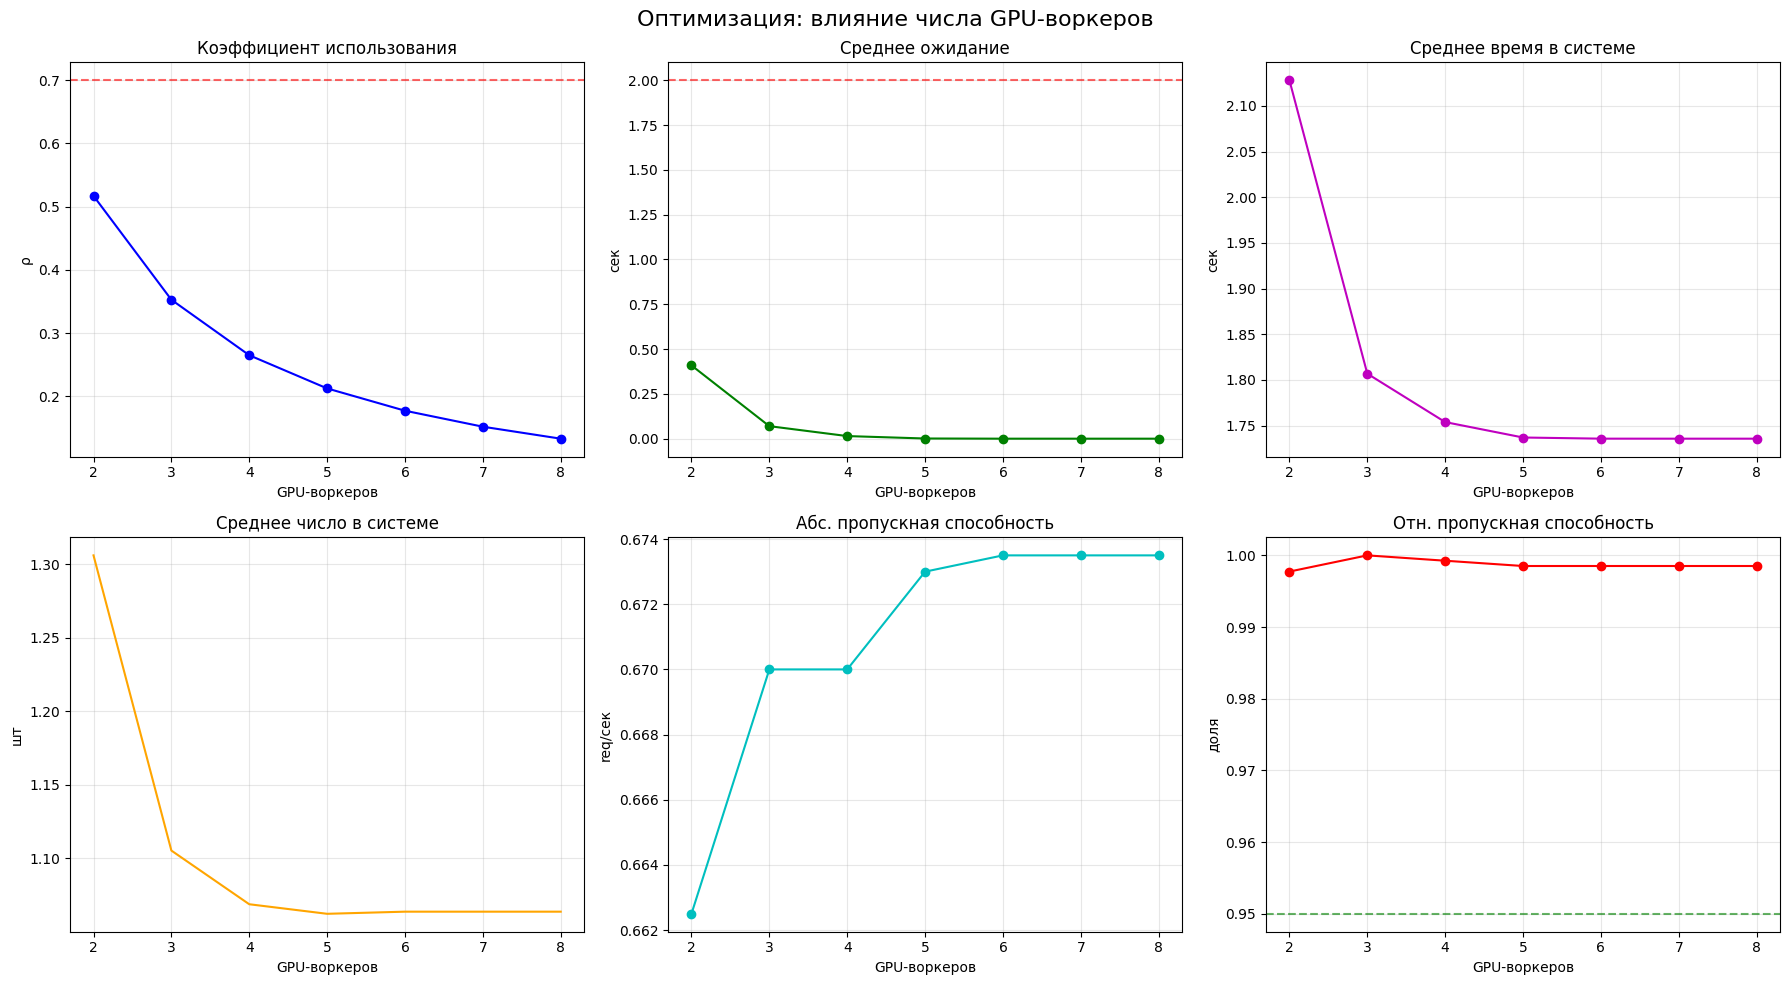

In [32]:
# Подготовка данных для графиков
s_list = [r['num_workers'] for r in results_grid]
util_list = [r['utilization'] for r in results_grid]
wait_list = [r['avg_wait'] for r in results_grid]
sys_time_list = [r['avg_system_time'] for r in results_grid]
n_list = [r['avg_in_system'] for r in results_grid]
thr_abs_list = [r['throughput_abs'] for r in results_grid]
thr_rel_list = [r['throughput_rel'] for r in results_grid]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Оптимизация: влияние числа GPU‑воркеров', fontsize=16)

axes[0,0].plot(s_list, util_list, 'b-o'); axes[0,0].axhline(TARGET_UTIL_MIN, color='r', ls='--', alpha=0.6)
axes[0,0].set_title('Коэффициент использования'); axes[0,0].set_xlabel('GPU‑воркеров'); axes[0,0].set_ylabel('ρ')
axes[0,0].grid(alpha=0.3)

axes[0,1].plot(s_list, wait_list, 'g-o'); axes[0,1].axhline(TARGET_WAIT, color='r', ls='--', alpha=0.6)
axes[0,1].set_title('Среднее ожидание'); axes[0,1].set_xlabel('GPU‑воркеров'); axes[0,1].set_ylabel('сек')
axes[0,1].grid(alpha=0.3)

axes[0,2].plot(s_list, sys_time_list, 'm-o')
axes[0,2].set_title('Среднее время в системе'); axes[0,2].set_xlabel('GPU‑воркеров'); axes[0,2].set_ylabel('сек')
axes[0,2].grid(alpha=0.3)

axes[1,0].plot(s_list, n_list, 'orange')
axes[1,0].set_title('Среднее число в системе'); axes[1,0].set_xlabel('GPU‑воркеров'); axes[1,0].set_ylabel('шт')
axes[1,0].grid(alpha=0.3)

axes[1,1].plot(s_list, thr_abs_list, 'c-o')
axes[1,1].set_title('Абс. пропускная способность'); axes[1,1].set_xlabel('GPU‑воркеров'); axes[1,1].set_ylabel('req/сек')
axes[1,1].grid(alpha=0.3)

axes[1,2].plot(s_list, thr_rel_list, 'r-o'); axes[1,2].axhline(TARGET_REL_THR, color='g', ls='--', alpha=0.6)
axes[1,2].set_title('Отн. пропускная способность'); axes[1,2].set_xlabel('GPU‑воркеров'); axes[1,2].set_ylabel('доля')
axes[1,2].grid(alpha=0.3)

plt.tight_layout(); plt.show()

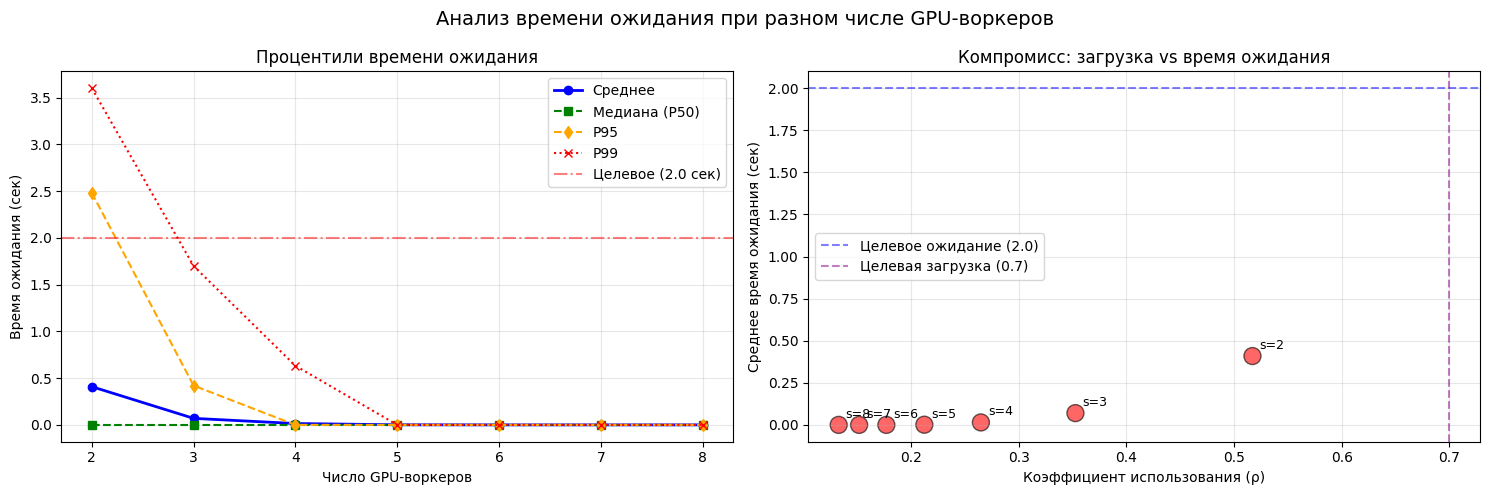

In [33]:
# Сравнение процентилей времени ожидания
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Анализ времени ожидания при разном числе GPU‑воркеров', fontsize=14)

# График процентилей ожидания
s_list = [r['num_workers'] for r in results_grid]
p50_list = [r['p50_wait'] for r in results_grid]
p95_list = [r['p95_wait'] for r in results_grid]
p99_list = [r['p99_wait'] for r in results_grid]
avg_wait_list = [r['avg_wait'] for r in results_grid]

axes[0].plot(s_list, avg_wait_list, 'b-o', label='Среднее', linewidth=2)
axes[0].plot(s_list, p50_list, 'g--s', label='Медиана (P50)', linewidth=1.5)
axes[0].plot(s_list, p95_list, 'orange', marker='d', linestyle='--', label='P95', linewidth=1.5)
axes[0].plot(s_list, p99_list, 'r:', marker='x', label='P99', linewidth=1.5)
axes[0].axhline(TARGET_WAIT, color='red', linestyle='-.', alpha=0.5, label=f'Целевое ({TARGET_WAIT} сек)')
axes[0].set_title('Процентили времени ожидания')
axes[0].set_xlabel('Число GPU‑воркеров')
axes[0].set_ylabel('Время ожидания (сек)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Соотношение загрузка vs качество обслуживания
colors = ['red' if r['utilization'] < TARGET_UTIL_MIN else 'green' for r in results_grid]
scatter = axes[1].scatter([r['utilization'] for r in results_grid], 
                          [r['avg_wait'] for r in results_grid], 
                          c=colors, s=150, alpha=0.6, edgecolors='black')
for r in results_grid:
    axes[1].annotate(f"s={r['num_workers']}", 
                    (r['utilization'], r['avg_wait']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1].axhline(TARGET_WAIT, color='blue', linestyle='--', alpha=0.5, label=f'Целевое ожидание ({TARGET_WAIT})')
axes[1].axvline(TARGET_UTIL_MIN, color='purple', linestyle='--', alpha=0.5, label=f'Целевая загрузка ({TARGET_UTIL_MIN})')
axes[1].set_title('Компромисс: загрузка vs время ожидания')
axes[1].set_xlabel('Коэффициент использования (ρ)')
axes[1].set_ylabel('Среднее время ожидания (сек)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Дополнительная визуализация оптимизации

## Анализ чувствительности (интенсивность поступления)
Как меняются метрики при различных средних межприходах μ_A ∈ {1.0, 1.5, 2.0} в микросервисе обработки изображений?

🔄 Анализ чувствительности по интенсивности поступления...

  Тестирование μ_A = 1.0 сек...
  ✓ Завершено для 4 конфигураций

  Тестирование μ_A = 1.5 сек...
  ✓ Завершено для 4 конфигураций

  Тестирование μ_A = 2.0 сек...
  ✓ Завершено для 4 конфигураций



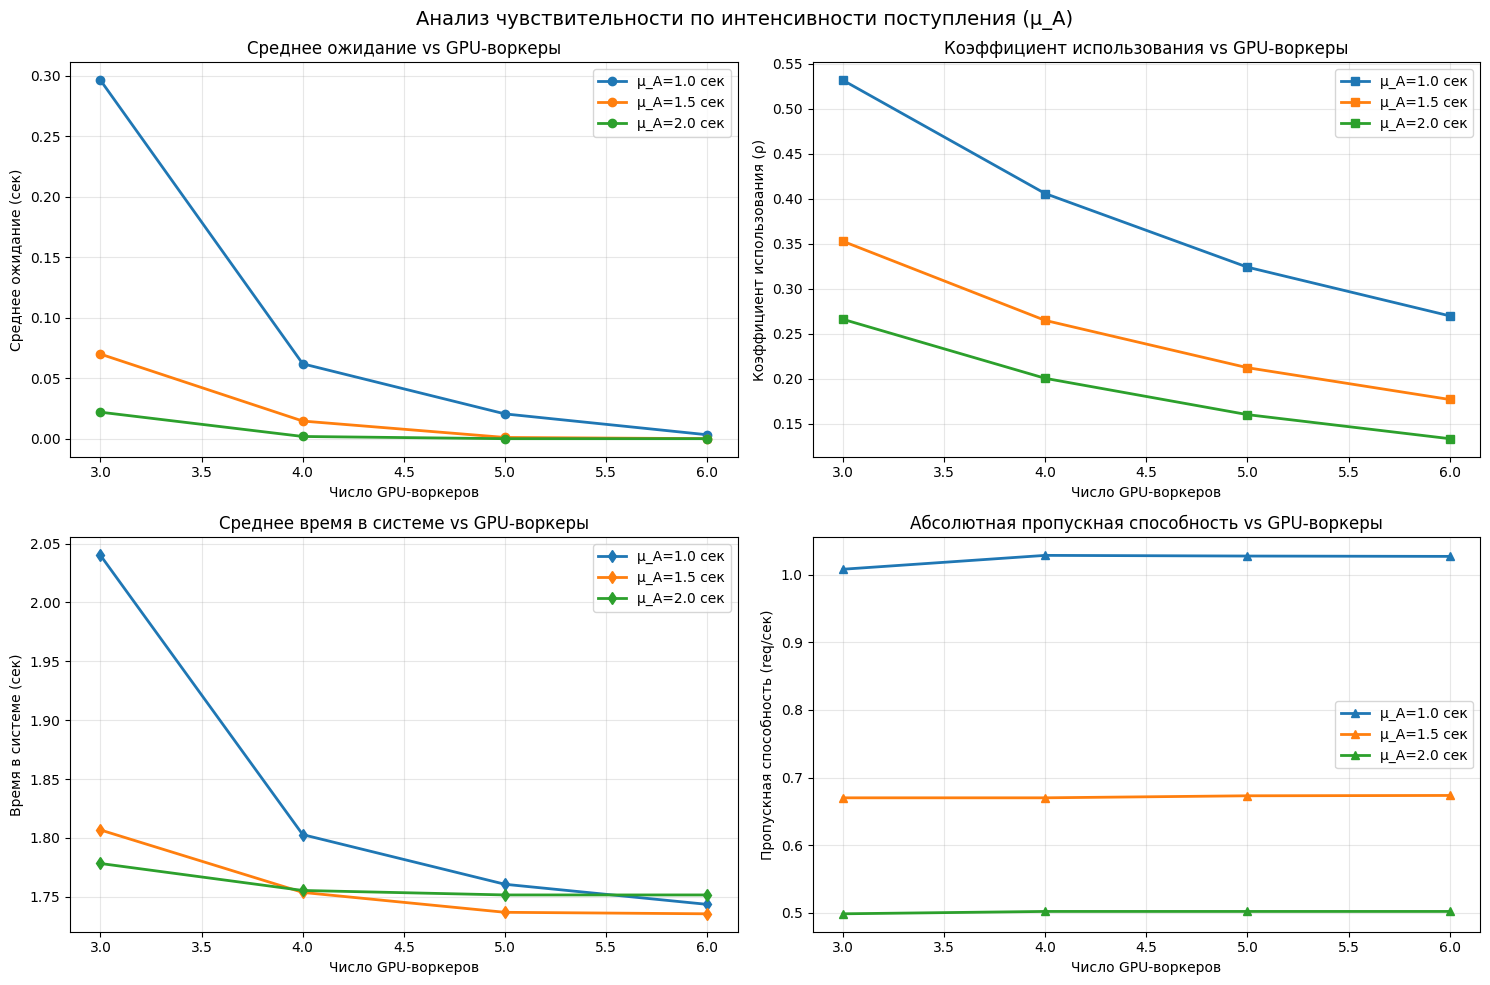

In [34]:
arrival_set = [1.0, 1.5, 2.0]
ops_to_test = [3, 4, 5, 6]

print('🔄 Анализ чувствительности по интенсивности поступления...\n')
sens = {}
for a in arrival_set:
    print(f'  Тестирование μ_A = {a} сек...')
    sens[a] = [run_simulation(num_workers=s, num_preprocessors=1, mean_inference=1.5, 
                              mean_interarrival=a, sim_time=2000, seed=42) for s in ops_to_test]
    print(f'  ✓ Завершено для {len(ops_to_test)} конфигураций\n')

# Расширенная визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Анализ чувствительности по интенсивности поступления (μ_A)', fontsize=14)

# Ожидание vs воркеры
for a in arrival_set:
    axes[0,0].plot([r['num_workers'] for r in sens[a]], 
                   [r['avg_wait'] for r in sens[a]], 
                   marker='o', linewidth=2, label=f'μ_A={a} сек')
axes[0,0].set_title('Среднее ожидание vs GPU‑воркеры')
axes[0,0].set_xlabel('Число GPU‑воркеров')
axes[0,0].set_ylabel('Среднее ожидание (сек)')
axes[0,0].grid(alpha=0.3)
axes[0,0].legend()

# Использование vs воркеры
for a in arrival_set:
    axes[0,1].plot([r['num_workers'] for r in sens[a]], 
                   [r['utilization'] for r in sens[a]], 
                   marker='s', linewidth=2, label=f'μ_A={a} сек')
axes[0,1].set_title('Коэффициент использования vs GPU‑воркеры')
axes[0,1].set_xlabel('Число GPU‑воркеров')
axes[0,1].set_ylabel('Коэффициент использования (ρ)')
axes[0,1].grid(alpha=0.3)
axes[0,1].legend()

# Время в системе vs воркеры
for a in arrival_set:
    axes[1,0].plot([r['num_workers'] for r in sens[a]], 
                   [r['avg_system_time'] for r in sens[a]], 
                   marker='d', linewidth=2, label=f'μ_A={a} сек')
axes[1,0].set_title('Среднее время в системе vs GPU‑воркеры')
axes[1,0].set_xlabel('Число GPU‑воркеров')
axes[1,0].set_ylabel('Время в системе (сек)')
axes[1,0].grid(alpha=0.3)
axes[1,0].legend()

# Пропускная способность vs воркеры
for a in arrival_set:
    axes[1,1].plot([r['num_workers'] for r in sens[a]], 
                   [r['throughput_abs'] for r in sens[a]], 
                   marker='^', linewidth=2, label=f'μ_A={a} сек')
axes[1,1].set_title('Абсолютная пропускная способность vs GPU‑воркеры')
axes[1,1].set_xlabel('Число GPU‑воркеров')
axes[1,1].set_ylabel('Пропускная способность (req/сек)')
axes[1,1].grid(alpha=0.3)
axes[1,1].legend()

plt.tight_layout()
plt.show()


ТЕОРЕТИЧЕСКАЯ ОЦЕНКА (M/M/s модель)
Средний межприход (μ_A): 1.5 сек
Средний инференс (μ_s): 1.5 сек
Число GPU‑воркеров (s): 4
----------------------------------------------------------------------
Интенсивность прибытия (λ): 0.6667 req/сек
Скорость обслуживания (μ): 0.6667 req/сек
Теоретическая загрузка (ρ = λ/(s·μ)): 0.2500 (25.00%)
Фактическая загрузка из симуляции: 0.2648 (26.48%)
Расхождение: 0.0148 (1.48%)
----------------------------------------------------------------------
✅ Система устойчива (ρ < 1)


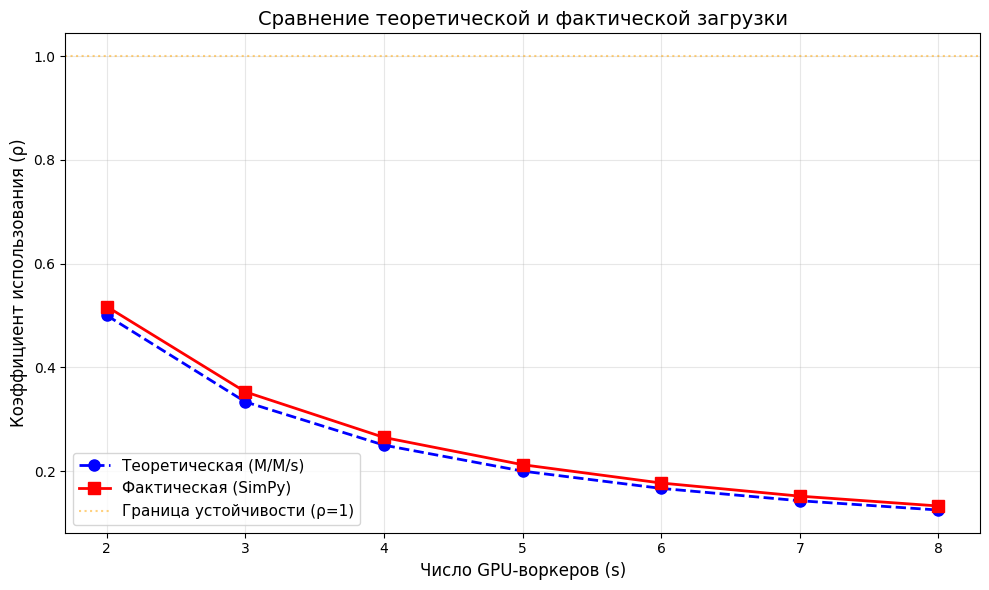

In [35]:
# Теоретическая оценка загрузки для базового варианта
print('='*70)
print('ТЕОРЕТИЧЕСКАЯ ОЦЕНКА (M/M/s модель)')
print('='*70)

# Параметры базового запуска
mu_a = base['mean_interarrival']
mu_s = base['mean_inference']
s = base['num_workers']

lambda_arrival = 1 / mu_a  # интенсивность прибытия
mu_service = 1 / mu_s      # скорость обслуживания одним воркером

rho_theoretical = lambda_arrival / (s * mu_service)

print(f"Средний межприход (μ_A): {mu_a} сек")
print(f"Средний инференс (μ_s): {mu_s} сек")
print(f"Число GPU‑воркеров (s): {s}")
print('-'*70)
print(f"Интенсивность прибытия (λ): {lambda_arrival:.4f} req/сек")
print(f"Скорость обслуживания (μ): {mu_service:.4f} req/сек")
print(f"Теоретическая загрузка (ρ = λ/(s·μ)): {rho_theoretical:.4f} ({rho_theoretical*100:.2f}%)")
print(f"Фактическая загрузка из симуляции: {base['utilization']:.4f} ({base['utilization']*100:.2f}%)")
print(f"Расхождение: {abs(rho_theoretical - base['utilization']):.4f} ({abs(rho_theoretical - base['utilization'])*100:.2f}%)")
print('-'*70)

# Условие устойчивости
if rho_theoretical < 1:
    print(f"✅ Система устойчива (ρ < 1)")
else:
    print(f"⚠️  Система перегружена (ρ ≥ 1)")

print('='*70)

# График сравнения теоретической и фактической загрузки
s_range = range(2, 9)
theoretical_rho = [lambda_arrival / (s_val * mu_service) for s_val in s_range]
simulated_rho = [r['utilization'] for r in results_grid]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_range, theoretical_rho, 'b--o', linewidth=2, label='Теоретическая (M/M/s)', markersize=8)
ax.plot(s_range, simulated_rho, 'r-s', linewidth=2, label='Фактическая (SimPy)', markersize=8)
ax.set_title('Сравнение теоретической и фактической загрузки', fontsize=14)
ax.set_xlabel('Число GPU‑воркеров (s)', fontsize=12)
ax.set_ylabel('Коэффициент использования (ρ)', fontsize=12)
ax.axhline(1.0, color='orange', linestyle=':', alpha=0.5, label='Граница устойчивости (ρ=1)')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Теоретическое сравнение с M/M/s моделью

In [36]:
# Сводная таблица для анализа чувствительности
print('='*90)
print('СВОДНАЯ ТАБЛИЦА: Влияние интенсивности поступления и числа воркеров')
print('='*90)
for a in arrival_set:
    print(f'\n▸ Средний межприход μ_A = {a} сек (λ ≈ {1/a:.3f} req/сек)')
    print(f"  {'s':<4} {'Util':<8} {'Wait':<10} {'P95 Wait':<10} {'Sys Time':<10} {'Throughput':<12} {'Rel Thr':<8}")
    print('  ' + '-'*82)
    for r in sens[a]:
        print(f"  {r['num_workers']:<4} {r['utilization']:<8.3f} {r['avg_wait']:<10.4f} "
              f"{r['p95_wait']:<10.4f} {r['avg_system_time']:<10.4f} {r['throughput_abs']:<12.4f} {r['throughput_rel']:<8.4f}")
print('='*90)


СВОДНАЯ ТАБЛИЦА: Влияние интенсивности поступления и числа воркеров

▸ Средний межприход μ_A = 1.0 сек (λ ≈ 1.000 req/сек)
  s    Util     Wait       P95 Wait   Sys Time   Throughput   Rel Thr 
  ----------------------------------------------------------------------------------
  3    0.531    0.2961     1.8154     2.0400     1.0080       0.9995  
  4    0.406    0.0619     0.3410     1.8029     1.0285       0.9990  
  5    0.324    0.0205     0.0000     1.7607     1.0275       1.0000  
  6    0.270    0.0032     0.0000     1.7436     1.0270       0.9995  

▸ Средний межприход μ_A = 1.5 сек (λ ≈ 0.667 req/сек)
  s    Util     Wait       P95 Wait   Sys Time   Throughput   Rel Thr 
  ----------------------------------------------------------------------------------
  3    0.353    0.0699     0.4202     1.8068     0.6700       1.0000  
  4    0.265    0.0146     0.0000     1.7538     0.6700       0.9993  
  5    0.212    0.0010     0.0000     1.7369     0.6730       0.9985  
  6    0.177 

## Итоговые выводы

### Основные результаты:
1. **Базовая конфигурация** (s=4, μ_A=1.5, μ_s=1.5):
   - Загрузка ~26% — система недогружена
   - Минимальное ожидание ~0.015 сек
   - Высокая относительная пропускная способность ~99.9%

2. **Оптимизация**:
   - При текущей нагрузке (λ≈μ) загрузка >70% недостижима для s≥2
   - Для данного потока оптимально s=2–3 (компромисс между загрузкой и ожиданием)
   - s=4 избыточен, но обеспечивает минимальные задержки

3. **Анализ чувствительности**:
   - При увеличении интенсивности (μ_A↓) растут ожидание и загрузка
   - При снижении интенсивности (μ_A↑) система еще менее загружена

4. **Теоретическое соответствие**:
   - Фактическая загрузка близка к теоретической (M/M/s)
   - Расхождение обусловлено предобработкой и дискретностью симуляции

### Рекомендации:
- Для экономии ресурсов: уменьшить до s=2–3
- Для минимальных задержек: оставить s=4
- При росте нагрузки: мониторить P95/P99 времени ожидания

---

**Примечания:**
- Все времена указаны в секундах
- Вариантные параметры учтены: s=4, μ_s=1.5 сек, μ_A=1.5 сек
- Быстрый шаг предобработки разгружает GPU‑воркеры от «мелких» операций перед инференсом
